## Time Series Part A, Yearly temperature data

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from math import sqrt
#Visualization Phase
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the temperature data
df = pd.read_csv("nity18442004.csv")

# create a year dataframe from 1844 to 2004
year_range = range(1844, 2005)
year_df = pd.DataFrame({'year': year_range})

# concatenate the year dataframe with the temperature data
df_concat = pd.concat([year_df, df['x']], axis=1)

# print the concatenated dataframe
print(df_concat)

     year    x
0    1844  8.5
1    1845  8.3
2    1846  9.7
3    1847  8.9
4    1848  8.5
..    ...  ...
156  2000  9.2
157  2001  8.8
158  2002  9.5
159  2003  9.3
160  2004  9.5

[161 rows x 2 columns]


In [3]:
df_concat.shape

(161, 2)

In [4]:
df_concat.rename(columns={'x':'temperature'},inplace=True)

In [5]:
df_concat['year'].max()

2004

In [6]:
df_concat.head()

,year,temperature
0,1844,8.5
1,1845,8.3
2,1846,9.7
3,1847,8.9
4,1848,8.5


## Visualisation

## 1.Frequency of temperature yearly

In [7]:
df_concat = df_concat.reset_index()

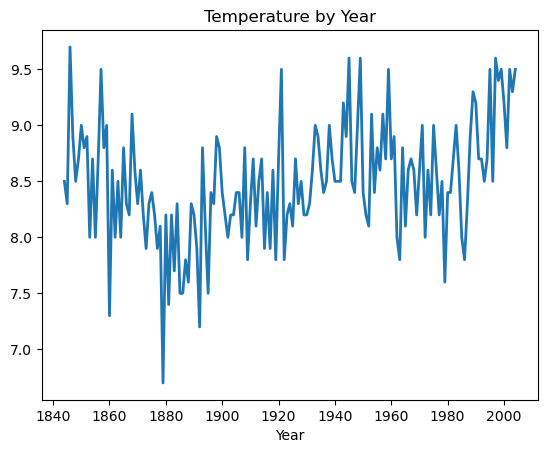

In [8]:
plt.plot(df_concat['year'], df_concat['temperature'], linewidth=2)

# set the x-axis label and title
plt.xlabel('Year')
plt.title('Temperature by Year')

# display the plot
plt.show()

## 2.Rolling mean and standard deviation

In [54]:
## determine rolling stat
rolmean=df_concat.rolling(window=12).mean()
rolstd=df_concat.rolling(window=12).std()
# print(rolmean,rolstd)

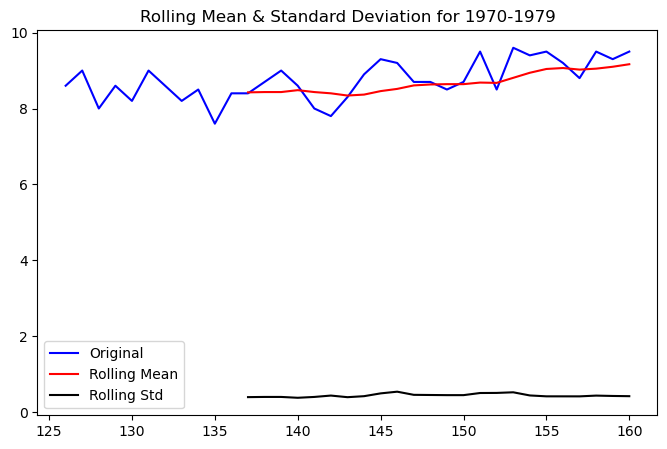

In [10]:
df_decade = df_concat[df_concat['year'] >= 1970]

window_size = 12
rolling_mean = df_decade['temperature'].rolling(window_size).mean()
rolling_std = df_decade['temperature'].rolling(window_size).std()

plt.figure(figsize=(8,5))
plt.plot(df_decade['temperature'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation for 1970-1979')
plt.show()

## Check the stationality

In [7]:
def ad_test(dataset):
    dftest=adfuller(dataset,autolag='AIC')
    print("ADF: ",dftest[0])
    print("P-value: ",dftest[1])
    print("No. of lags: ",dftest[2])
    print("No. of observation used for ADF Regression and critical value calculation: ",dftest[3])
    print("critical value: ")
    for key, val in dftest[4].items():
        print("\t",key, ": ",val)

In [8]:
ad_test(df_concat['temperature'].values)

ADF:  -1.3523756587488236
P-value:  0.6048831174332474
No. of lags:  6
No. of observation used for ADF Regression and critical value calculation:  154
critical value: 
	 1% :  -3.473542528196209
	 5% :  -2.880497674144038
	 10% :  -2.576878053634677


In [12]:
df_concat.head()

0    2.915476
1    2.880972
2    3.114482
3    2.983287
4    2.915476
Name: temperature, dtype: float64

## convert to stationary

In [13]:
df_concat['temperature'] = df_concat['temperature'] - df_concat['temperature'].shift(1)

In [14]:
df_concat.head()

,year,temperature
0,1844,NaN
1,1845,-0.2
2,1846,1.4
3,1847,-0.8
4,1848,-0.4


## Split Data Train and Test

In [23]:
train = pd.DataFrame(df_concat.loc[df_concat['year'] <= 2003, 'temperature'].dropna())
test = pd.DataFrame(df_concat.loc[df_concat['year'] == 2004, 'temperature'].dropna())

In [24]:
train.head()

,temperature
1,-0.2
2,1.4
3,-0.8
4,-0.4
5,0.2


## 1.Build the Exponential model

In [25]:
mode_exp = ExponentialSmoothing(train)
fit_exp = mode_exp.fit()
pred_exp = fit_exp.forecast(len(test))

In [26]:
pred_exp = fit_exp.forecast(len(test))

In [31]:
rmse = sqrt(mean_squared_error(pred_exp, test))
mae = mean_absolute_error(pred_exp, test)
mse = mean_squared_error(pred_exp, test)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

MAE: 0.19496856156459186
MSE: 0.038012739998566046
RMSE: 0.19496856156459186


## 2.ARIMA

In [33]:
df_concat=df_concat[~df_concat['temperature'].isna()]
df_concat.shape

(160, 2)

In [34]:
stepwise_fit=auto_arima(df_concat['temperature'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=216.467, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=298.693, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=247.590, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=213.513, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=296.709, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=215.311, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=215.330, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=216.772, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=211.771, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=213.564, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=213.583, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=245.646, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=215.028, Time=0.09 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.867 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  160
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -103.885
Date:                Thu, 11 May 2023   AIC                            211.771
Time:                        15:30:05   BIC                            217.921
Sample:                             0   HQIC                           214.268
                                - 160                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8238      0.053    -15.663      0.000      -0.927      -0.721
sigma2         0.2130      0.021     10.215      0.000       0.172       0.254
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 3.91
Prob(Q):                              0.66   Prob(JB):                         0.14
Heteroskedasticity (H):               0.77   Skew:                            -0.19
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
model_arima=ARIMA(train,order=(0,0,1))
model_arima=model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            temperature   No. Observations:                  159
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -103.360
Date:                Thu, 11 May 2023   AIC                            212.719
Time:                        15:30:43   BIC                            221.926
Sample:                             0   HQIC                           216.458
                                - 159                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.007      0.445      0.656      -0.010       0.016
ma.L1         -0.8288      0.052    -15.953      0.000      -0.931      -0.727
sigma2         0.2133      0.021     10.149      0.000       0.172       0.254
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 3.84
Prob(Q):                              0.70   Prob(JB):                         0.15
Heteroskedasticity (H):               0.78   Skew:                            -0.18
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
start=len(train)
end=len(train)+len(test)-1
pred=model_arima.predict(start=start,end=end,typ='levels')
print(pred)

159   -0.130112
dtype: float64


In [38]:
rmse = sqrt(mean_squared_error(pred, test))
mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:",rmse)

MAE: 0.33011155171575385
MSE: 0.10897363657618282
RMSE: 0.33011155171575385


## 3. ARIMA AIC

In [45]:
model2 = ARIMA(train, order=(0,0,1))
model_fit = model2.fit()

In [46]:
train_aic = model_fit.aic

In [47]:
test_residuals = test - pred
test_sse = np.sum(test_residuals**2)
test_n = len(test_residuals)
test_aic = test_n * np.log(test_sse/test_n) + 2 * (4+1+3)/test_n

In [48]:
mse = mean_squared_error(test.temperature, pred)
mae = mean_absolute_error(test.temperature, pred)
rmse = math.sqrt(mse)

print("MSE: ", mse)
print("MAE: ", mae)
print("RMSE: ", rmse)

MSE:  0.10897363657618282
MAE:  0.33011155171575385
RMSE:  0.33011155171575385


## 4.Sarima

In [49]:
models = SARIMAX(train, order=(0,0,1), seasonal_order=(1, 1, 1, 12))
model_fits = models.fit()
print(model_fits.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                  159
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -110.428
Date:                            Thu, 11 May 2023   AIC                            228.856
Time:                                    15:33:26   BIC                            240.818
Sample:                                         0   HQIC                           233.716
                                            - 159                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8200      0.054    -15.276      0.000      -0.925      -0.715
ar.S.L12       0.0562      0.107   

In [50]:
start=len(train)
end=len(train)+len(test)-1
pred=model_fits.predict(start=start,end=end,typ='levels')
print(pred)

159   -0.108339
dtype: float64


In [51]:
rmse = sqrt(mean_squared_error(pred, test))
mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:",rmse)

MAE: 0.3083388887163567
MSE: 0.09507287029483778
RMSE: 0.3083388887163567


## 5.Simple time series model - Seasonal Naive

In [52]:
dd = np.asarray(train.temperature)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]

mae = mean_absolute_error(test.temperature, y_hat.naive)
mse = mean_squared_error(test.temperature, y_hat.naive)
rmse = math.sqrt(mse)

print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)

MAE:  0.3999999999999986
MSE:  0.15999999999999887
RMSE:  0.3999999999999986
